In [20]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyEDM import CCM

def ccm_significance_statistic(ds_sat, df_pre, ds_sat_ens, lat_idx, lon_idx, samples, 
                     E_val, tau_val, Tp_val, libSizes, show_figures=True):
    """
    Run CCM analysis at a specified grid point using the mean SAT, ensemble SAT, 
    and an interpolated version of pre with random age shifts.
    
    Parameters:
        ds_sat      : xarray.Dataset 
                      Mean SAT dataset (must include 'sat', 'age', 'lat', and 'lon').
        df_pre      : pandas.DataFrame 
                      Pre dataset (must include 'pre' and 'age' columns).
        ds_sat_ens  : xarray.Dataset 
                      Ensemble SAT dataset (must include 'sat', 'lat', 'lon', and 'age').
        lat_idx     : int
                      Index for the latitude grid.
        lon_idx     : int
                      Index for the longitude grid.
        samples     : int
                      Number of ensemble members (and random age series) to use.
        E_val       : int
                      Embedding dimension.
        tau_val     : int
                      Time delay.
        Tp_val      : int
                      Prediction horizon.
        libSizes    : str
                      Library sizes for CCM (e.g. "10 20 30 40 50 60 70").
        show_figures: bool, optional
                      If True, display intermediate plots (default is True).
    
    Returns:
        dict : A dictionary with the following keys:
            "ccm_mean"         - CCM result (DataFrame) from the mean SAT.
            "ensemble_ccm"     - List of CCM results (DataFrames) from the shifted ensemble.
            "sat_mean"         - 1D array of the mean SAT time series.
            "sat_ens_shifted"  - 2D array (samples x time) of shifted ensemble SAT data.
            "pre_ran"          - 2D array (samples x time) of interpolated pre data.
            "time"             - 1D array of the time coordinate.
    """
    # ---------------------------
    # 1. Data extraction and sampling
    # ---------------------------
    time = ds_sat['age'].values
    sat_mean = ds_sat['sat'].isel(lat=lat_idx, lon=lon_idx).values
    sat_ens = ds_sat_ens['sat'].isel(lat=lat_idx, lon=lon_idx).values
    
    # Randomly select "samples" ensemble members
    sat_ens = sat_ens[np.random.choice(sat_ens.shape[0], samples, replace=False), :]
    
    # ---------------------------
    # 2. Generate random age series and interpolate pre for each sample
    # ---------------------------
    nTime = len(time)
    # For each time point, generate a random integer between (time[i]-100) and (time[i]+100)
    sat_age_ran = np.empty((samples, nTime))
    for i in range(samples):
        # np.random.randint can work with arrays if low and high are arrays
        sat_age_ran[i] = np.random.randint(time - 100, time + 100)
    
    pre_arr = df_pre['pre'].values
    pre_age = df_pre['age'].values  
    pre_ran = np.empty((samples, len(pre_age)))
    for i in range(samples):
        pre_ran[i] = np.interp(sat_age_ran[i], pre_age, pre_arr)
    
    # ---------------------------
    # 3. Plot Mean SAT and ensemble members (original)
    # ---------------------------
    if show_figures:
        plt.figure(figsize=(10, 5))
        for i in range(sat_ens.shape[0]):
            plt.plot(time, sat_ens[i, :], color='gray', alpha=0.3)
        plt.plot(time, sat_mean, color='k', lw=2, label='Mean SAT')
        plt.xlabel("Time (age)")
        plt.ylabel("SAT")
        plt.title(f"Mean SAT vs. Ensemble SAT at lat={int(ds_sat['lat'].values[lat_idx])}, lon={ds_sat['lon'].values[lon_idx]}")
        plt.legend()
        plt.show()
    
    # ---------------------------
    # 4. Create shifted ensemble data by breaking and swapping halves
    # ---------------------------
    half = nTime // 2
    sat_ens_shifted = np.empty_like(sat_ens)
    for i in range(sat_ens.shape[0]):
        ts = sat_ens[i, :]
        shifted_ts = np.concatenate((ts[half:], ts[:half]))
        sat_ens_shifted[i, :] = shifted_ts
    
    if show_figures:
        plt.figure(figsize=(10, 5))
        for i in range(sat_ens_shifted.shape[0]):
            plt.plot(time, sat_ens_shifted[i, :], color='orange', alpha=0.2)
        plt.plot(time, sat_mean, color='k', lw=2, label='Mean SAT')
        plt.xlabel("Time (age)")
        plt.ylabel("SAT")
        plt.title("Mean SAT vs. Shifted Ensemble SAT")
        plt.legend()
        plt.show()
    
    # ---------------------------
    # 5. CCM analysis using the mean SAT and pre data
    # ---------------------------
    df_ccm = pd.DataFrame({
        'Time': time,
        'X': sat_mean,
        'Y': df_pre['pre'].values
    })
    ccm_out = CCM(
        dataFrame   = df_ccm,
        E           = E_val,
        tau         = tau_val,
        columns     = "X",   # SAT manifold
        target      = "Y",   # predict pre
        libSizes    = libSizes,
        sample      = 10,
        random      = True,
        replacement = False,
        Tp          = Tp_val
    )
    
    # ---------------------------
    # 6. CCM analysis for each shifted ensemble member using its corresponding interpolated pre
    # ---------------------------
    ensemble_ccm = []
    for i in range(sat_ens_shifted.shape[0]):
        df_temp = pd.DataFrame({
            'Time': time,
            'X': sat_ens_shifted[i, :],
            'Y': pre_ran[i]
        })
        try:
            out = CCM(
                dataFrame   = df_temp,
                E           = E_val,
                tau         = tau_val,
                columns     = "X",
                target      = "Y",
                libSizes    = libSizes,
                sample      = 10,
                random      = True,
                replacement = False,
                Tp          = Tp_val
            )
            ensemble_ccm.append(out)
        except Exception as e:
            print(f"Error in ensemble member {i}: {e}")
    
    # ---------------------------
    # 7. Plot the CCM curves in a subplot with two panels
    # ---------------------------
    if show_figures:
        fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
        
        # Left subplot: SAT -> pre (using "X:Y")
        ax = axes[0]
        for i, out in enumerate(ensemble_ccm):
            label = 'Ensemble SAT CCM' if i == 0 else None
            ax.plot(out['LibSize'], out['X:Y'], color='lightcoral', linestyle='-', alpha=0.3, label=label)
        ax.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'ro-', label='Mean SAT CCM')
        ax.set_xlabel("Library Size")
        ax.set_ylabel("Prediction Skill (rho)")
        ax.set_title(r'$\hat{pre}|M_{sat}$')
        
        # Right subplot: pre -> SAT (using "Y:X")
        ax2 = axes[1]
        for i, out in enumerate(ensemble_ccm):
            label = 'Ensemble pre CCM' if i == 0 else None
            ax2.plot(out['LibSize'], out['Y:X'], color='skyblue', linestyle='-', alpha=0.1, label=label)
        ax2.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'bo-', label='Mean pre CCM')
        ax2.set_xlabel("Library Size")
        ax2.set_ylabel("Prediction Skill (rho)")
        ax2.set_title(r'$\hat{sat}|M_{pre}$')
        
        plt.tight_layout()
        plt.show()
    
    # ---------------------------
    # 8. Return results
    # ---------------------------
    return {
        "ccm_mean": ccm_out,
        "ensemble_ccm": ensemble_ccm,
        "sat_mean": sat_mean,
        "sat_ens_shifted": sat_ens_shifted,
        "pre_ran": pre_ran,
        "time": time
    }


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


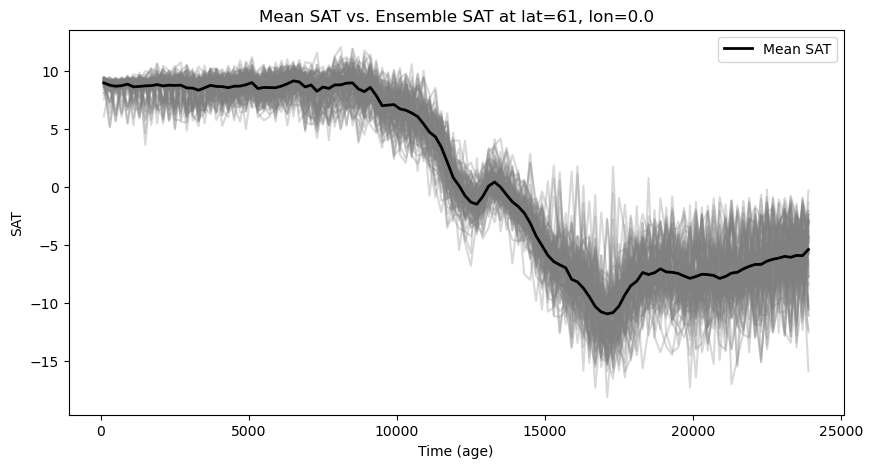

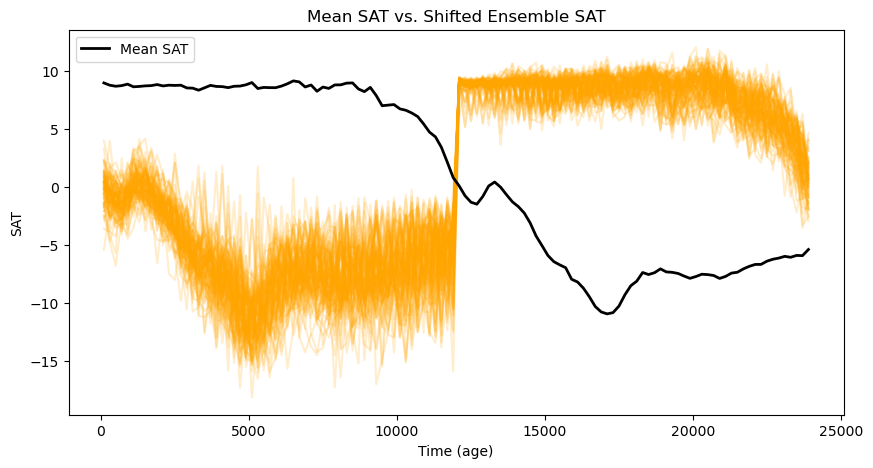

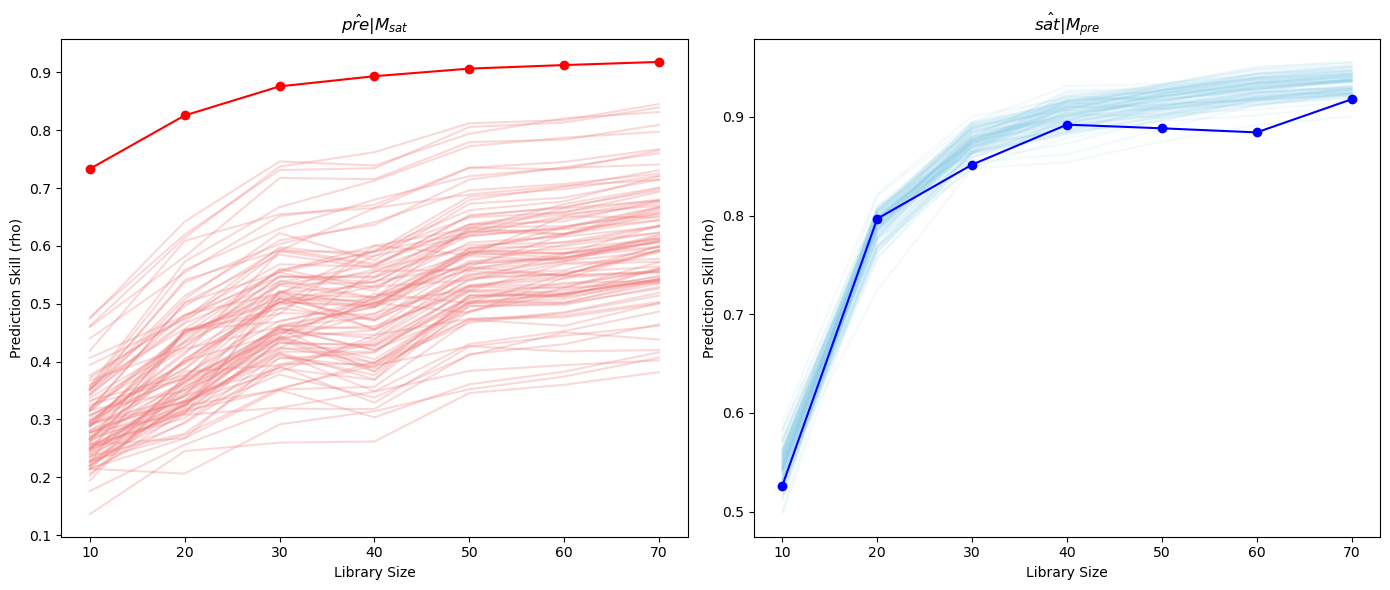

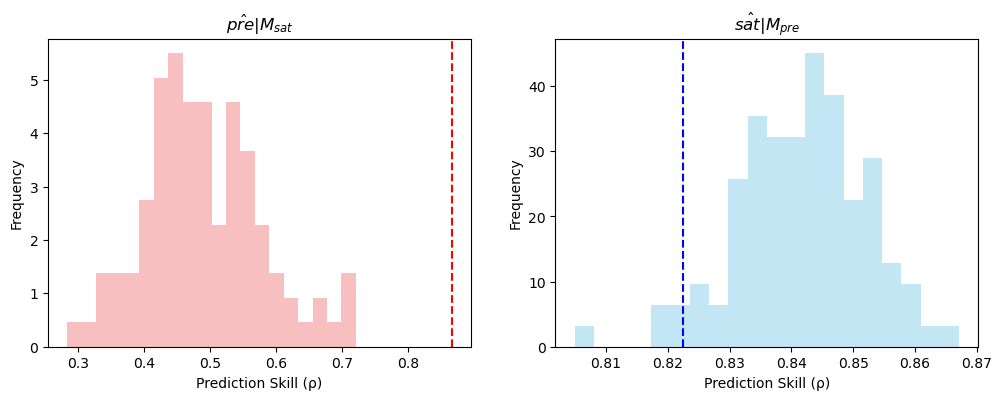

In [21]:
results = ccm_significance_statistic(
    ds_sat= xr.open_dataset('LGMR_data/LGMR_SAT_climo.nc'),
    df_pre= pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\pre.csv"),
    ds_sat_ens= xr.open_dataset('LGMR_data/LGMR_SAT_ens.nc'),
    lat_idx=80,
    lon_idx=0,
    samples=100,
    E_val=4,
    tau_val=3,
    Tp_val=0,
    libSizes="10 20 30 40 50 60 70",
    show_figures=True
)

ccm_out = results["ccm_mean"]
ensemble_ccm = results["ensemble_ccm"]

test_result = ccm_significance_test(ccm_out, ensemble_ccm, if_plot=True)


In [22]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyEDM import CCM
import cartopy.crs as ccrs
import cartopy.feature as cfeature



def global_ccm_significance_map(ds_sat, df_pre, ds_sat_ens, samples, 
                                E_val, tau_val, Tp_val, libSizes, show_figures=False):
    """
    Loop over all grid points in ds_sat and ds_sat_ens, compute the CCM analysis and significance
    test for each grid point, and then plot a global map (Robinson projection) with coastlines
    overlaying the boolean significance results.
    
    Parameters:
      ds_sat     : xarray.Dataset with mean SAT data.
      df_pre     : pandas.DataFrame with pre data.
      ds_sat_ens : xarray.Dataset with ensemble SAT data.
      samples    : int, number of ensemble members to use.
      E_val, tau_val, Tp_val, libSizes : CCM parameters.
      show_figures: bool, if True, intermediate plots (per grid point) are shown.
    
    Returns:
      significance_map : 2D boolean numpy array (shape: [nlat, nlon]) with True/False significance.
    """
    nlat = ds_sat.sizes["lat"]
    nlon = ds_sat.sizes["lon"]
    significance_map = np.full((nlat, nlon), False, dtype=bool)
    
    # Loop over every grid point.
    for i in range(nlat):
        for j in range(nlon):
            # Suppress plotting during per–grid–point analysis
            results = ccm_significance_statistic(ds_sat, df_pre, ds_sat_ens, lat_idx=i, lon_idx=j, 
                                       samples=samples, E_val=E_val, tau_val=tau_val, Tp_val=Tp_val,
                                       libSizes=libSizes, show_figures=False)
            ccm_mean = results["ccm_mean"]
            ensemble_ccm = results["ensemble_ccm"]
            test_result = ccm_significance_test(ccm_mean, ensemble_ccm, if_plot=False)
            significance_map[i, j] = test_result
            print(f"Processed grid point: lat index={i}, lon index={j}, significance={test_result}")
    
    # Plot the global map
    lats = ds_sat["lat"].values
    lons = ds_sat["lon"].values
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    pcm = ax.pcolormesh(lon_grid, lat_grid, significance_map.astype(int),
                        transform=ccrs.PlateCarree(), cmap=plt.cm.Reds, vmin=0, vmax=1)
    cb = plt.colorbar(pcm, ax=ax, orientation="horizontal", pad=0.05)
    cb.set_label("Significance (1: True, 0: False)")
    ax.set_title("Global CCM Significance Map")
    plt.show()
    
    return significance_map

# =========================
# Example of calling the functions:
# =========================

# First, run the global analysis over all grid points.
global_significance = global_ccm_significance_map(
    ds_sat = xr.open_dataset('LGMR_data/LGMR_SAT_climo.nc'),
    df_pre = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\pre.csv"),
    ds_sat_ens = xr.open_dataset('LGMR_data/LGMR_SAT_ens.nc'),
    samples = 100,
    E_val = 4,
    tau_val = 3,
    Tp_val = 0,
    libSizes = "10 20 30 40 50 60 70",
    show_figures = False
)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=0, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=1, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=0, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=3, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=22, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=23, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=25, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=27, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=32, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=2, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=0, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=1, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=3, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=5, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=6, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=18, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=21, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=22, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=23, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=27, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=139, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=140, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=142, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=3, lon index=143, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=5, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=6, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=18, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=22, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=23, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=30, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=32, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=33, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=37, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=40, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=81, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=82, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=88, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=89, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=119, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=4, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=18, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=22, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=28, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=29, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=30, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=31, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=32, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=33, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=34, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=35, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=36, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=37, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=38, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=79, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=80, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=81, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=82, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=83, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=84, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=139, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=140, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=5, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=5, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=6, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=18, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=32, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=35, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=37, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=38, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=40, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=42, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=71, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=72, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=80, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=81, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=82, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=83, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=6, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=3, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=5, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=6, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=41, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=70, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=7, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=3, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=5, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=25, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=34, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=36, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=37, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=40, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=85, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=88, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=8, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=3, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=5, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=87, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=90, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=101, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=102, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=121, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=9, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=1, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=3, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=5, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=6, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=100, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=103, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=105, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=106, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=107, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=108, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=109, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=110, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=111, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=112, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=139, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=140, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=142, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=10, lon index=143, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=1, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=3, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=5, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=6, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=27, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=30, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=31, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=104, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=105, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=107, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=108, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=109, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=110, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=111, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=112, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=139, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=140, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=142, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=11, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=0, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=1, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=3, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=5, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=6, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=18, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=24, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=25, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=27, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=29, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=106, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=107, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=108, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=109, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=110, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=111, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=112, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=139, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=140, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=142, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=12, lon index=143, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=0, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=1, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=3, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=5, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=6, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=18, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=21, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=22, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=23, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=24, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=25, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=27, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=101, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=102, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=103, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=104, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=105, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=106, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=107, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=108, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=109, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=110, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=111, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=112, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=139, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=140, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=142, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=13, lon index=143, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=0, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=1, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=3, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=5, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=6, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=18, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=21, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=22, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=23, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=24, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=25, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=27, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=28, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=102, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=105, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=106, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=107, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=108, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=109, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=110, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=111, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=112, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=119, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=139, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=140, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=142, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=14, lon index=143, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=0, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=1, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=3, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=5, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=6, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=18, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=21, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=22, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=23, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=24, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=25, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=27, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=28, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=98, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=100, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=102, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=104, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=105, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=106, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=107, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=108, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=109, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=110, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=111, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=112, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=119, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=120, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=121, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=139, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=140, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=142, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=15, lon index=143, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=0, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=1, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=3, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=5, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=6, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=18, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=21, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=22, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=23, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=24, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=25, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=29, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=30, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=31, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=33, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=37, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=38, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=97, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=99, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=100, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=101, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=102, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=103, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=104, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=105, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=106, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=107, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=108, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=109, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=110, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=111, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=112, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=119, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=120, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=121, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=140, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=142, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=16, lon index=143, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=1, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=6, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=18, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=21, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=22, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=23, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=24, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=25, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=27, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=29, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=30, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=33, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=35, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=36, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=92, significance=False
Processed grid point: lat index=17, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=101, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=102, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=104, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=105, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=106, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=107, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=108, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=109, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=110, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=111, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=112, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=119, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=120, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=121, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=17, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=18, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=21, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=22, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=23, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=24, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=25, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=27, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=28, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=29, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=30, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=32, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=37, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=103, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=105, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=106, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=107, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=108, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=109, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=110, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=111, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=112, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=119, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=120, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=121, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=18, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=18, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=21, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=22, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=23, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=24, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=25, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=27, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=28, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=29, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=30, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=31, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=33, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=34, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=35, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=36, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=37, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=39, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=42, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=43, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=104, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=106, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=107, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=108, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=110, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=111, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=112, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=119, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=120, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=121, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=139, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=140, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=19, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=0, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=1, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=3, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=5, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=18, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=21, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=22, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=23, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=24, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=25, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=27, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=28, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=29, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=30, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=31, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=32, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=33, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=34, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=35, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=36, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=37, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=39, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=40, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=41, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=42, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=44, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=109, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=110, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=111, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=112, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=119, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=120, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=121, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=139, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=140, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=142, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=20, lon index=143, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=0, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=1, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=5, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=6, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=16, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=17, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=18, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=21, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=22, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=23, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=24, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=25, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=27, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=28, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=29, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=30, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=31, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=32, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=33, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=35, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=39, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=40, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=43, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=110, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=111, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=112, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=119, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=120, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=121, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=139, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=140, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=142, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=21, lon index=143, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=0, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=1, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=19, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=22, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=23, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=24, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=25, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=27, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=28, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=29, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=30, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=107, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=109, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=110, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=112, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=119, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=120, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=121, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=139, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=140, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=142, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=22, lon index=143, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=0, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=2, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=20, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=24, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=26, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=28, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=112, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=119, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=120, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=121, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=139, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=140, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=142, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=23, lon index=143, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=1, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=4, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=121, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=139, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=140, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=142, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=24, lon index=143, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=139, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=25, lon index=143, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=141, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=142, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=26, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=138, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=27, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=137, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=28, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=0, significance=False
Processed grid point: lat index=29, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=135, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=136, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=29, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=133, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=30, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=120, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=130, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=132, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=134, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=31, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=116, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=119, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=120, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=131, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=32, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=119, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=120, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=129, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=33, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=11, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=121, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=34, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=121, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=128, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=35, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=10, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=125, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=126, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=127, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=36, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=62, significance=False
Processed grid point: lat index=37, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=37, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=12, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=38, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=98, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=100, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=101, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=102, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=103, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=39, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=13, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=14, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=15, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=98, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=99, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=100, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=101, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=102, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=103, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=105, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=40, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=9, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=99, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=100, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=101, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=102, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=103, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=104, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=41, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=50, significance=False
Processed grid point: lat index=42, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=95, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=99, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=100, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=101, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=102, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=103, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=104, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=105, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=113, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=114, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=42, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=93, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=95, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=96, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=97, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=98, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=99, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=100, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=101, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=102, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=103, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=104, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=105, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=43, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=93, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=94, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=95, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=96, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=97, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=98, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=99, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=100, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=101, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=102, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=103, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=104, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=44, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=101, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=103, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=112, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=121, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=45, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=118, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=121, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=122, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=124, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=46, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=119, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=47, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=115, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=117, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=119, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=123, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=48, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=7, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=8, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=21, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=22, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=23, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=24, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=25, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=26, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=27, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=28, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=29, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=30, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=31, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=32, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=33, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=34, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=35, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=36, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=37, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=38, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=39, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=40, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=41, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=42, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=43, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=44, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=45, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=46, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=47, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=48, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=49, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=50, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=51, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=52, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=53, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=54, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=55, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=56, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=57, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=58, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=59, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=60, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=61, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=62, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=63, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=64, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=65, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=66, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=67, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=68, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=69, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=70, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=71, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=72, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=73, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=74, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=75, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=76, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=77, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=78, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=79, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=80, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=81, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=82, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=83, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=84, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=85, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=86, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=87, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=88, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=89, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=90, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=91, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=92, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=93, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=94, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=95, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=96, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=97, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=98, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=99, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=100, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=101, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=102, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=103, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=104, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=105, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=106, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=107, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=108, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=109, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=110, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=111, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=112, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=113, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=114, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=115, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=116, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=117, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=118, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=119, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=120, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=121, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=122, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=123, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=124, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=125, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=126, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=127, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=128, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=129, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=130, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=131, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=132, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=133, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=134, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=135, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=136, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=137, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=138, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=139, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=140, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=141, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=142, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=49, lon index=143, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=0, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=1, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=2, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=3, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=4, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=5, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=6, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=7, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=8, significance=True


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=9, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=10, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=11, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=12, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=13, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=14, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=15, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=16, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=17, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=18, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=19, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


Processed grid point: lat index=50, lon index=20, significance=False


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


KeyboardInterrupt: 

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


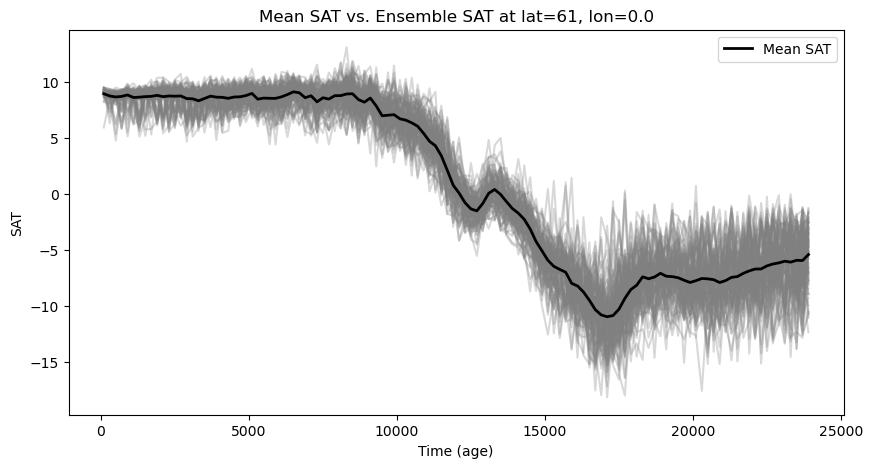

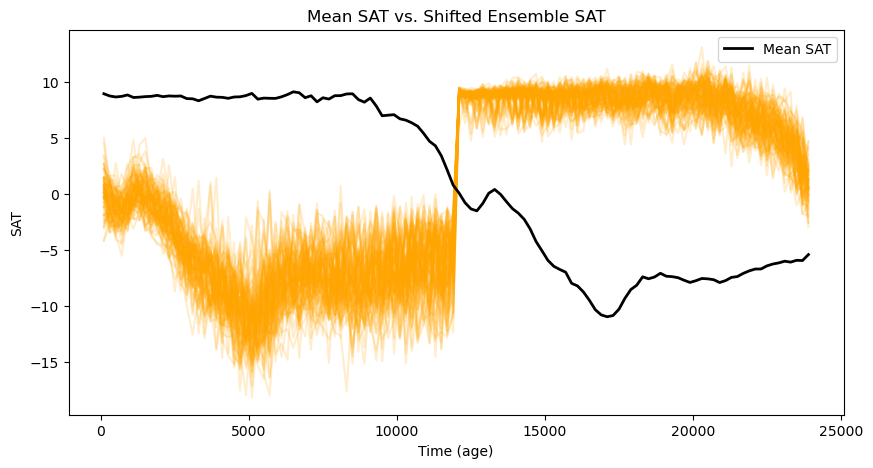

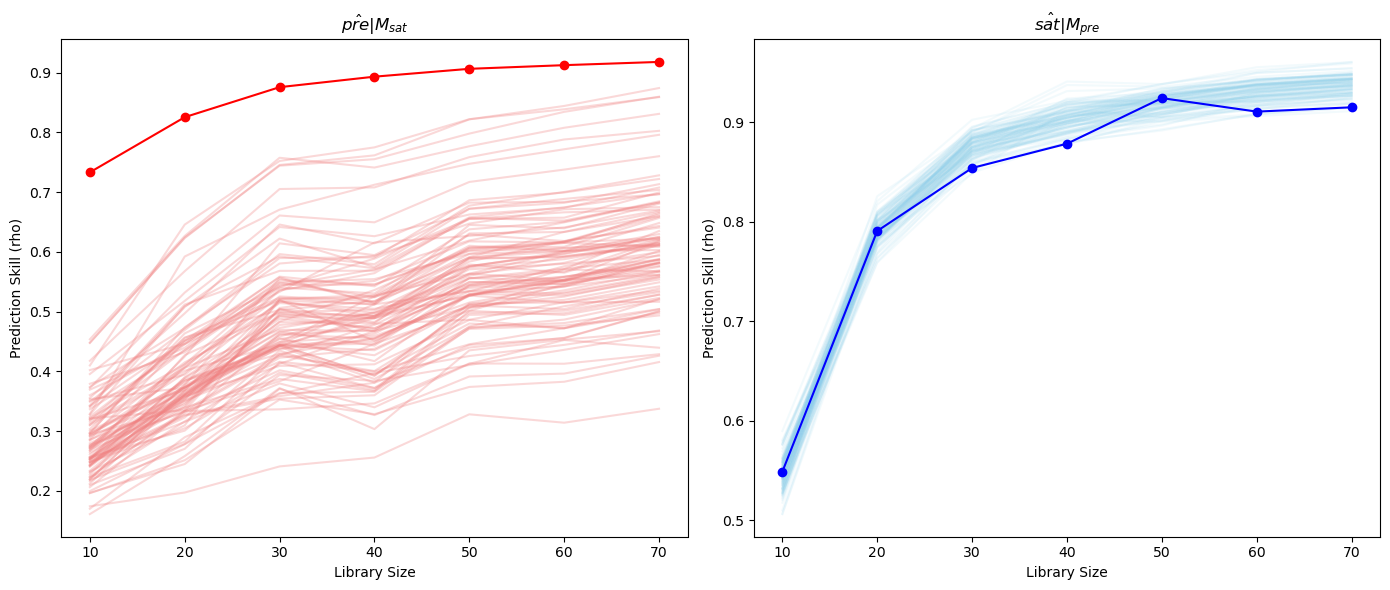

In [12]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyEDM import CCM

# ---------------------------
# Load data
# ---------------------------
ds_sat = xr.open_dataset('LGMR_data/LGMR_SAT_climo.nc')
df_pre = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\pre.csv")
ds_sat_ens = xr.open_dataset('LGMR_data/LGMR_SAT_ens.nc')

# ---------------------------
# Select a grid point for testing
# ---------------------------
lat_idx = 80
lon_idx = 0
time = ds_sat['age'].values

# Mean SAT time series at the selected grid point
sat_mean = ds_sat['sat'].isel(lat=lat_idx, lon=lon_idx).values

# Ensemble SAT data at the same grid point (shape: nEns x time)
sat_ens = ds_sat_ens['sat'].isel(lat=lat_idx, lon=lon_idx).values

samples=100

# from sat_ens randomly select n=samples
sat_ens = sat_ens[np.random.choice(sat_ens.shape[0], samples, replace=False), :]



# generate n=sampels random age series, each age in each series is between  sat[age][i]-100 to sat[age][i]+99 
sat_age_ran=np.empty((samples,len(time)))
for i in range(samples):
    sat_age_ran[i]=np.random.randint(time-100,time+100)

# convert columns of df_pre to numpy array
pre = df_pre['pre'].values
pre_age = df_pre['age'].values  

# create a interpolated pre series for each sat_age_ran
pre_ran = np.empty((samples,len(pre_age)))
for i in range(samples):
    pre_ran[i] = np.interp(sat_age_ran[i],pre_age,pre)

# ---------------------------
# 1. (Already plotted earlier) Plot mean SAT and ensemble members
# ---------------------------
plt.figure(figsize=(10, 5))
for i in range(sat_ens.shape[0]):
    plt.plot(time, sat_ens[i, :], color='gray', alpha=0.3)
plt.plot(time, sat_mean, color='k', lw=2, label='Mean SAT')
plt.xlabel("Time (age)")
plt.ylabel("SAT")
plt.title(f"Mean SAT vs. Ensemble SAT at lat={int(ds_sat['lat'].values[lat_idx])}, lon={ds_sat['lon'].values[lon_idx]}")
plt.legend()
plt.show()

# ---------------------------
# 2. Create shifted ensemble data
# ---------------------------
nTime = len(time)
half = nTime // 2
sat_ens_shifted = np.empty_like(sat_ens)
for i in range(sat_ens.shape[0]):
    ts = sat_ens[i, :]
    shifted_ts = np.concatenate((ts[half:], ts[:half]))
    sat_ens_shifted[i, :] = shifted_ts

plt.figure(figsize=(10, 5))
for i in range(sat_ens_shifted.shape[0]):
    plt.plot(time, sat_ens_shifted[i, :], color='orange', alpha=0.2)
plt.plot(time, sat_mean, color='k', lw=2, label='Mean SAT')
plt.xlabel("Time (age)")
plt.ylabel("SAT")
plt.title("Mean SAT vs. Shifted Ensemble SAT")
plt.legend()
plt.show()

# ---------------------------
# 3. Set CCM parameters and run CCM (one call returns both directions)
# ---------------------------
E_val = 4
tau_val = 3
Tp_val = 0
libSizes = "10 20 30 40 50 60 70"

# Prepare a common DataFrame for the mean SAT and pre data
df_ccm = pd.DataFrame({
    'Time': time,
    'X': sat_mean,
    'Y': df_pre['pre'].values
})
# Run CCM once: X is SAT and Y is pre. We assume the output DataFrame contains both "X:Y" and "Y:X"
ccm_out = CCM(
    dataFrame   = df_ccm,
    E           = E_val,
    tau         = tau_val,
    columns     = "X",   # SAT manifold
    target      = "Y",   # predict pre
    libSizes    = libSizes,
    sample      = 10,
    random      = True,
    replacement = False,
    Tp          = Tp_val
)

# For each ensemble member (shifted), compute CCM in the same way
ensemble_ccm = []
for i in range(sat_ens_shifted.shape[0]):
    df_temp = pd.DataFrame({
        'Time': time,
        'X': sat_ens_shifted[i, :],
        'Y': pre_ran[i]
    })
    try:
        out = CCM(
            dataFrame   = df_temp,
            E           = E_val,
            tau         = tau_val,
            columns     = "X",
            target      = "Y",
            libSizes    = libSizes,
            sample      = 10,
            random      = True,
            replacement = False,
            Tp          = Tp_val
        )
        ensemble_ccm.append(out)
    except Exception as e:
        print(f"Error in ensemble member {i}: {e}")

# ---------------------------
# 4. Plot the CCM curves in a subplot with two panels using the two output columns
# ---------------------------
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# --- Left subplot: SAT -> pre (use "X:Y") ---
ax = axes[0]
for i, out in enumerate(ensemble_ccm):
    label = 'Ensemble SAT CCM' if i == 0 else None
    ax.plot(out['LibSize'], out['X:Y'], color='lightcoral', linestyle='-', alpha=0.3, label=label)
ax.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'ro-', label='Mean SAT CCM')
ax.set_xlabel("Library Size")
ax.set_ylabel("Prediction Skill (rho)")
ax.set_title(r'$\hat{pre}|M_{sat}$')
# ax.legend()

# --- Right subplot: pre -> SAT (use "Y:X") ---
ax2 = axes[1]
for i, out in enumerate(ensemble_ccm):
    label = 'Ensemble pre CCM' if i == 0 else None
    ax2.plot(out['LibSize'], out['Y:X'], color='skyblue', linestyle='-', alpha=0.1, label=label)
ax2.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'bo-', label='Mean pre CCM')
ax2.set_xlabel("Library Size")
ax2.set_ylabel("Prediction Skill (rho)")
ax2.set_title(r'$\hat{sat}|M_{pre}$')
# ax2.legend()

plt.tight_layout()
plt.show()


In [17]:
def ccm_significance_test(ccm_mean, ensemble_ccm, if_plot=False):
    """
    Test whether the CCM result for the mean is significantly different from that of the shifted ensemble.
    
    Parameters:
      ccm_mean : pandas.DataFrame
          CCM output for the mean data. Must contain columns "LibSize", "X:Y", and "Y:X".
      ensemble_ccm : list of pandas.DataFrame
          A list of CCM outputs for each ensemble member, with the same columns as ccm_mean.
          
    Returns:
      bool: True if the CCM using SAT to predict pre is significantly different 
            (i.e. the mean value is outside the 5th-95th percentile of the ensemble) 
            AND the CCM using pre to predict SAT is not significant (i.e. the mean falls 
            within the ensemble range). Returns False otherwise.
    """
    # Use the maximum LibSize as the test point.
    max_lib = ccm_mean["LibSize"].max()
    
    # Extract mean values at the maximum LibSize.
    # mean_sat2pre = ccm_mean.loc[ccm_mean["LibSize"] == max_lib, "X:Y"].values[0]
    # mean_pre2sat = ccm_mean.loc[ccm_mean["LibSize"] == max_lib, "Y:X"].values[0]

    mean_sat2pre = np.mean(ccm_mean['X:Y'])
    mean_pre2sat = np.mean(ccm_mean['Y:X'])
    
    # Gather ensemble values at the maximum LibSize.
    ens_sat2pre = []
    ens_pre2sat = []
    for ens_df in ensemble_ccm:
        try:
            # val_sat2pre = ens_df.loc[ens_df["LibSize"] == max_lib, "X:Y"].values[0]
            # val_pre2sat = ens_df.loc[ens_df["LibSize"] == max_lib, "Y:X"].values[0]
            val_sat2pre = np.mean(ens_df['X:Y'])
            val_pre2sat = np.mean(ens_df['Y:X'])
            ens_sat2pre.append(val_sat2pre)
            ens_pre2sat.append(val_pre2sat)
        except Exception as e:
            print(f"Error extracting ensemble data: {e}")
    
    ens_sat2pre = np.array(ens_sat2pre)
    ens_pre2sat = np.array(ens_pre2sat)

    if if_plot:
        # plot the histogram of the ensemble values and a vertical line for the mean
        fig, axes = plt.subplots(1, 2, figsize=(12, 4),dpi=100)
        ax1 = axes[0]
        ax2 = axes[1]
        ax1.hist(ens_sat2pre, bins=20, density=True, color='lightcoral', alpha=0.5, label='Ensemble SAT->pre')
        ax1.axvline(mean_sat2pre, color='red', linestyle='--', label='Mean SAT->pre')
        ax1.set_title(r'$\hat{pre}|M_{sat}$')
        # add x-axis label
        ax1.set_xlabel("Prediction Skill (ρ)")
        ax1.set_ylabel("Frequency")
   

        # ax1.legend()
        ax2.hist(ens_pre2sat, bins=20, density=True, color='skyblue', alpha=0.5, label='Ensemble pre->SAT')
        ax2.axvline(mean_pre2sat, color='blue', linestyle='--', label='Mean pre->SAT')
        ax2.set_title(r'$\hat{sat}|M_{pre}$')
        # add x-axis label
        ax2.set_xlabel("Prediction Skill (ρ)")
        ax2.set_ylabel("Frequency")


        # ax2.legend()
        plt.show()
    
    # Compute the 5th and 95th percentiles of the ensemble distributions.
    lower_sat2pre = np.percentile(ens_sat2pre, 5)
    upper_sat2pre = np.percentile(ens_sat2pre, 95)
    lower_pre2sat = np.percentile(ens_pre2sat, 5)
    upper_pre2sat = np.percentile(ens_pre2sat, 95)
    
    # Condition 1: Mean SAT->pre prediction (X:Y) is outside the ensemble range.
    significant_sat2pre = (mean_sat2pre > upper_sat2pre) or (mean_sat2pre < lower_sat2pre)
    
    # Condition 2: Mean pre->SAT prediction (Y:X) is within the ensemble range.
    non_significant_pre2sat = (lower_pre2sat <= mean_pre2sat <= upper_pre2sat)
    
    return significant_sat2pre and non_significant_pre2sat

# Example usage:
# result = ccm_significance_test(ccm_out, ensemble_ccm)
# print("Significant (SAT significantly predicts pre, while pre does not predict SAT):", result)


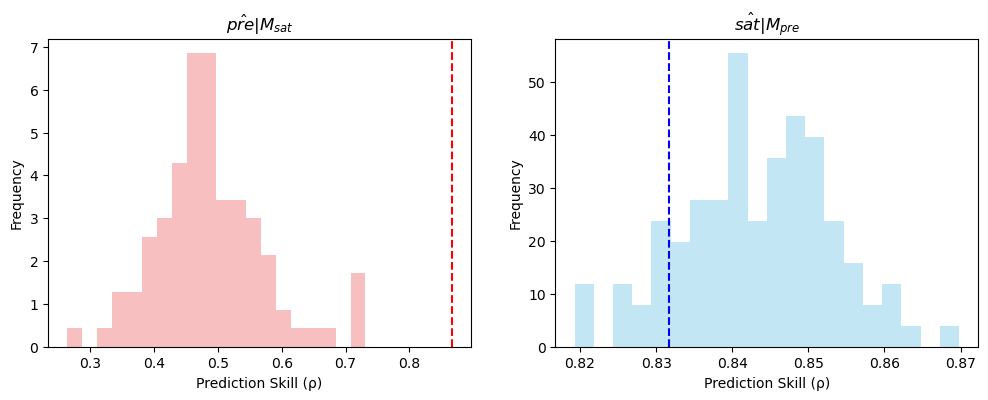

True

In [14]:
result = ccm_significance_test(ccm_out, ensemble_ccm, if_plot=True)
result

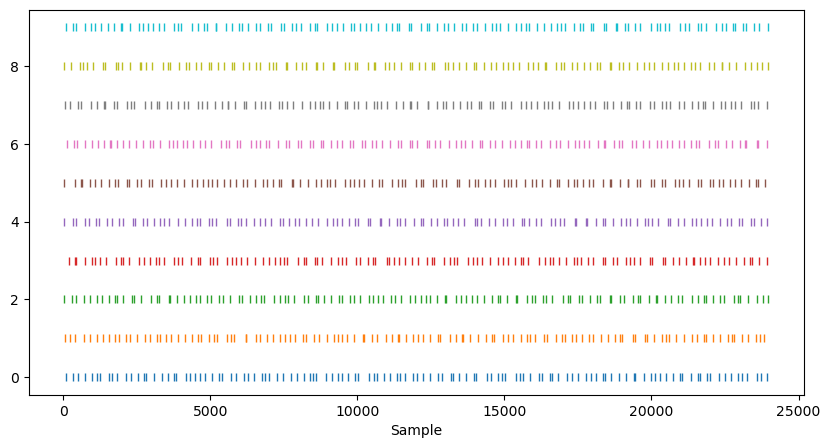

In [ ]:
samples=10
sat_age_ran=np.empty((samples,len(sat_age)))
for i in range(samples):
    sat_age_ran[i]=np.random.randint(sat_age-100,sat_age+100)

# visualize sat_age_ran, for each column, plot the value as vertical lines in the x-axis
plt.figure(figsize=(10,5))
plt.plot(sat_age_ran.T,np.tile(np.arange(samples),(sat_age_ran.shape[1],1)),'|')
plt.xlabel('Sample')


# convert columns of df_pre to numpy array
pre = df_pre['pre'].values
pre_age = df_pre['age'].values  

# create a interpolated pre series for each sat_age_ran
pre_ran = np.empty((samples,len(pre_age)))
for i in range(samples):
    pre_ran[i] = np.interp(sat_age_ran[i],pre_age,pre)


# # plot all pre_ran
# plt.figure(figsize=(10,5))
# plt.plot(sat_age_ran.T,pre_ran.T)
# plt.xlabel('Sample')
